In [1]:
# Memory configuration
import os
os.environ['JAX_LOG_COMPILES'] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import blackjax
import matplotlib.pyplot as plt
from astropy.time import Time
import tqdm
import sys
#sys.path.append('../')

jax.config.update("jax_enable_x64", True)

# Import gravitational wave functions
from jimgw.single_event.detector import H1, L1, V1
from jimgw.single_event.likelihood import phase_marginalized_likelihood as likelihood_function_phase_marginalized
from jimgw.single_event.likelihood import original_likelihood as likelihood_function
from jimgw.single_event.waveform import RippleIMRPhenomD

# Import custom Bilby adaptive kernel for unit cube
from custom_ns_kernels import (
    bilby_adaptive_de_sampler_unit_cube,
    create_unit_cube_functions,
    init_unit_cube_particles,
    transform_to_physical
)

from custom_ns_kernels import(
    bilby_adaptive_de_sampler_unit_cube_tuple, 
    create_unit_cube_functions_tuple, 
    init_unit_cube_particles_tuple, 
    transform_to_physical_tuple
)

# Initialize waveform
waveform = RippleIMRPhenomD(f_ref=50)

# Noise curve paths
asd_paths = {
    "H1": "/mnt/data/myp23/env/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt",
    "L1": "/mnt/data/myp23/env/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt", 
    "V1": "/mnt/data/myp23/env/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt",
}

# Injection parameters
injection_params = {
    "M_c": jnp.array(35.0),
    "q": jnp.array(0.9),
    "s1_z": jnp.array(0.4),
    "s2_z": jnp.array(-0.3),
    "d_L": jnp.array(1000.0),
    "iota": jnp.array(0.4),
    "t_c": jnp.array(0.0),
    "phase_c": jnp.array(1.3),
    "ra": jnp.array(1.375),
    "dec": jnp.array(-1.2108),
    "psi": jnp.array(2.659),
    "eta": jnp.array(0.9 / (1 + 0.9) ** 2),
}

# Need to reorder sampled_config to ravel order
def get_ravel_order(particles_dict):
    """Determine the order that ravel_pytree uses for flattening."""
    example = jax.tree_util.tree_map(lambda x: x[0], particles_dict)
    flat, _ = jax.flatten_util.ravel_pytree(example)
    
    # Create a test dict with unique values to identify the order
    test_dict = {key: float(i) for i, key in enumerate(particles_dict.keys())}
    test_flat, _ = jax.flatten_util.ravel_pytree(test_dict)
    
    # The order is determined by the positions in the flattened array
    order = []
    for val in test_flat:
        for key, test_val in test_dict.items():
            if abs(val - test_val) < 1e-10:
                order.append(key)
                break
    return order

Finished tracing + transforming convert_element_type for pjit in 0.000437737 sec
Compiling convert_element_type with global shapes and types [ShapedArray(float32[0])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.003947496 sec
Finished XLA compilation of jit(convert_element_type) in 0.028704166 sec
/mnt/data/myp23/env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
impo

In [3]:
# Load detector data as JAX arrays
detector_data = {
    'frequencies': jnp.array(np.load('4s_frequency_array.npy')),
    'H1': jnp.array(np.load('4s_H1_strain.npy')),
    'L1': jnp.array(np.load('4s_L1_strain.npy')),
    'V1': jnp.array(np.load('4s_V1_strain.npy'))
}

print(f"Loaded detector data as JAX arrays")

Finished tracing + transforming convert_element_type for pjit in 0.000357151 sec
Compiling convert_element_type with global shapes and types [ShapedArray(float64[4097])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002689362 sec
Finished XLA compilation of jit(convert_element_type) in 0.008620262 sec
Finished tracing + transforming convert_element_type for pjit in 0.001421928 sec
Compiling convert_element_type with global shapes and types [ShapedArray(complex128[4097])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002642870 sec
Finished XLA compilation of jit(convert_element_type) in 0.008614540 sec


Loaded detector data as JAX arrays


In [4]:
# Configure detector frequency range
freq_range = {'min': 20.0, 'max': 1024.0}

freq_mask = (detector_data['frequencies'] >= freq_range['min']) & (detector_data['frequencies'] <= freq_range['max'])
filtered_frequencies = detector_data['frequencies'][freq_mask]

# Configure detectors
detectors = [H1, L1, V1]
detector_names = ['H1', 'L1', 'V1']

for det, name in zip(detectors, detector_names):
    det.frequencies = filtered_frequencies  
    det.data = detector_data[name][freq_mask]

print(f"Configured {len(detectors)} detectors with {len(filtered_frequencies)} frequency points")

Finished tracing + transforming greater_equal for pjit in 0.000633240 sec
Compiling greater_equal with global shapes and types [ShapedArray(float64[4097]), ShapedArray(float64[], weak_type=True)]. Argument mapping: (UnspecifiedValue, UnspecifiedValue).
Finished jaxpr to MLIR module conversion jit(greater_equal) in 0.003732920 sec
Finished XLA compilation of jit(greater_equal) in 0.028004646 sec
Finished tracing + transforming less_equal for pjit in 0.000919104 sec
Compiling less_equal with global shapes and types [ShapedArray(float64[4097]), ShapedArray(float64[], weak_type=True)]. Argument mapping: (UnspecifiedValue, UnspecifiedValue).
Finished jaxpr to MLIR module conversion jit(less_equal) in 0.003432274 sec
Finished XLA compilation of jit(less_equal) in 0.028036833 sec
Finished tracing + transforming bitwise_and for pjit in 0.000673771 sec
Compiling bitwise_and with global shapes and types [ShapedArray(bool[4097]), ShapedArray(bool[4097])]. Argument mapping: (UnspecifiedValue, Unsp

Configured 3 detectors with 4017 frequency points


In [5]:
# Load PSD data for all detectors
def load_psd_data(asd_paths):
    psd_data = {}
    for name, path in asd_paths.items():
        f_np, asd_vals_np = np.loadtxt(path, unpack=True)
        psd_data[name] = {
            'frequencies': jnp.array(f_np),
            'psd': jnp.array(asd_vals_np**2)
        }
    return psd_data

psd_data = load_psd_data(asd_paths)

@jax.jit
def interpolate_psd(det_frequencies, psd_frequencies, psd_values):
    return jnp.interp(det_frequencies, psd_frequencies, psd_values)

# Configure detector PSDs
for det in detectors:
    det.psd = interpolate_psd(
        det.frequencies,
        psd_data[det.name]['frequencies'],
        psd_data[det.name]['psd']
    )

print(f"Configured PSDs for {len(detectors)} detectors")

Finished tracing + transforming convert_element_type for pjit in 0.000462532 sec
Compiling convert_element_type with global shapes and types [ShapedArray(float64[2736])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002771854 sec
Finished XLA compilation of jit(convert_element_type) in 0.008619308 sec
Finished tracing + transforming convert_element_type for pjit in 0.000666618 sec
Compiling convert_element_type with global shapes and types [ShapedArray(float64[3000])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.002898455 sec
Finished XLA compilation of jit(convert_element_type) in 0.008640289 sec
Finished tracing + transforming _squeeze for pjit in 0.000313997 sec
Finished tracing + transforming add for pjit in 0.000423193 sec
Finished tracing + transforming not_equal for pjit in 0.000439644 sec
Finished tracing + transforming not_equal for pjit in 0.000

Configured PSDs for 3 detectors


In [6]:
# Define sampled parameters (excludes phase_c for phase marginalization)
sample_keys = ["M_c", "q", "s1_z", "s2_z", "iota", "d_L", "t_c", "psi", "ra", "dec", "phase_c"]

# Get sample_keys in correct ravel order
test_particles = {}
for i, key in enumerate(sample_keys):
    test_particles[key] = jax.random.uniform(jax.random.PRNGKey(42), 100)

sample_keys = get_ravel_order(test_particles)

# Parameter configuration
param_config = {
    "M_c": {"min": 25.0, "max": 50.0, "prior": "uniform", "wraparound": False, "angle": 1.0},
    "q": {"min": 0.25, "max": 1.0, "prior": "uniform", "wraparound": False, "angle": 1.0},
    "s1_z": {"min": -1.0, "max": 1.0, "prior": "uniform", "wraparound": False, "angle": 1.0},
    "s2_z": {"min": -1.0, "max": 1.0, "prior": "uniform", "wraparound": False, "angle": 1.0},
    "iota": {"min": 0.0, "max": jnp.pi, "prior": "sine", "wraparound": False, "angle": 1.0},
    #"d_L": {"min": 100.0, "max": 5000.0, "prior": "beta", "wraparound": False, "angle": 1.0},
    "d_L": {"min": 100.0, "max": 5000.0, "prior": "powerlaw", "wraparound": False, "angle": 1.0},
    "t_c": {"min": -0.1, "max": 0.1, "prior": "uniform", "wraparound": False, "angle": 1.0},
    "phase_c": {"min": 0.0, "max": 2*jnp.pi, "prior": "uniform", "wraparound": True, "angle": 2*jnp.pi},
    "psi": {"min": 0.0, "max": jnp.pi, "prior": "uniform", "wraparound": True, "angle": jnp.pi},
    "ra": {"min": 0.0, "max": 2*jnp.pi, "prior": "uniform", "wraparound": True, "angle": 2*jnp.pi},
    "dec": {"min": -jnp.pi/2, "max": jnp.pi/2, "prior": "cosine", "wraparound": False, "angle": 1.0},
}

sampled_config = {key: param_config[key] for key in sample_keys}
n_dims = len(sample_keys)

# Pre-compute parameter arrays
param_mins = jnp.array([sampled_config[key]["min"] for key in sample_keys])
param_maxs = jnp.array([sampled_config[key]["max"] for key in sample_keys])
param_prior_types = jnp.array([
    0 if sampled_config[key]["prior"] == "uniform" else
    1 if sampled_config[key]["prior"] == "sine" else
    2 if sampled_config[key]["prior"] == "cosine" else
    3 for key in sample_keys
])

print(f"Sampling over {n_dims} parameters: {sample_keys}")
print(f"Wraparound parameters: {[key for key in sample_keys if sampled_config[key]['wraparound']]}")
print("Using PHASE MARGINALIZED LIKELIHOOD")

Finished tracing + transforming convert_element_type for pjit in 0.000394821 sec
Compiling convert_element_type with global shapes and types [ShapedArray(int64[])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.003338099 sec
Finished XLA compilation of jit(convert_element_type) in 0.008362770 sec
Finished tracing + transforming bitwise_and for pjit in 0.000571251 sec
Finished tracing + transforming _threefry_seed for pjit in 0.003437519 sec
Compiling _threefry_seed with global shapes and types [ShapedArray(int64[])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(_threefry_seed) in 0.004555464 sec
Finished XLA compilation of jit(_threefry_seed) in 0.027418852 sec
Finished tracing + transforming subtract for pjit in 0.000453472 sec
Finished tracing + transforming subtract for pjit in 0.000416517 sec
Finished tracing + transforming multiply for pjit in 0.000419617 sec
Finished tracing + 

Sampling over 11 parameters: ['M_c', 'd_L', 'dec', 'iota', 'phase_c', 'psi', 'q', 'ra', 's1_z', 's2_z', 't_c']
Wraparound parameters: ['phase_c', 'psi', 'ra']
Using PHASE MARGINALIZED LIKELIHOOD


In [7]:
# Constants for likelihood computation
post_trigger_duration = 2
duration = 4
epoch = duration - post_trigger_duration
gmst = Time(1126259642.413, format="gps").sidereal_time("apparent", "greenwich").rad

# Column labels for plotting
column_to_label = {
    "M_c": r"$M_c$", "q": r"$q$", "d_L": r"$d_L$", "iota": r"$\iota$", "ra": r"$\alpha$",
    "dec": r"$\delta$", "s1_z": r"$s_{1z}$", "s2_z": r"$s_{2z}$", "t_c": r"$t_c$", 
    "psi": r"$\psi$", "phase_c": r"$\phi_c$",
}

# Vectorized prior transforms for unit cube [0,1] -> physical space
@jax.jit
def uniform_transform(u, a, b):
    return a + u * (b - a)

@jax.jit  
def sine_transform(u):
    return jnp.arccos(1 - 2 * u)

@jax.jit
def cosine_transform(u):  
    return jnp.arcsin(2 * u - 1)

@jax.jit
def beta_transform(u, a, b):
    """Beta(3,1) transform using analytical inverse CDF."""
    beta_sample = jnp.cbrt(u)  # Cube root for Beta(3,1)
    return a + (b - a) * beta_sample

@jax.jit
def powerlaw_transform(u, alpha, min, max):
    return (min ** (1+alpha) + u * (max ** (1+alpha) - min ** (1+alpha))) ** (1/(1+alpha))

@jax.jit
def prior_transform_fn(u_params):
    """Transform unit cube to physical parameters."""
    u_values, _ = jax.flatten_util.ravel_pytree(u_params)
    
    # Apply transforms based on prior type
    uniform_vals = uniform_transform(u_values, param_mins, param_maxs)
    sine_vals = sine_transform(u_values)
    cosine_vals = cosine_transform(u_values)  
    #beta_vals = beta_transform(u_values, param_mins, param_maxs)
    powerlaw_vals = powerlaw_transform(u_values, 2, param_mins, param_maxs)

    x_values = jnp.where(
        param_prior_types == 0, uniform_vals,
        jnp.where(
            param_prior_types == 1, sine_vals,
            jnp.where(
                param_prior_types == 2, cosine_vals,
                #beta_vals
                powerlaw_vals
            )
        )
    )
    
    # Reconstruct parameter dict
    example_params = {key: 0.0 for key in sample_keys}
    _, unflatten_fn = jax.flatten_util.ravel_pytree(example_params)
    return unflatten_fn(x_values)

def loglikelihood_fn(params):
    """Phase marginalized likelihood function."""
    p = injection_params.copy()
    p.update(params)
    p["gmst"] = gmst
    p["eta"] = p["q"] / (1 + p["q"]) ** 2
    
    waveform_sky = waveform(filtered_frequencies, p)
    align_time = jnp.exp(-1j * 2 * jnp.pi * filtered_frequencies * (epoch + p["t_c"]))
    return likelihood_function(p, waveform_sky, detectors, filtered_frequencies, align_time)

# Vectorized prior functions for physical space (used in unit cube wrapper)
@jax.jit
def uniform_logprob(x, a, b):
    return jnp.where((x >= a) & (x <= b), -jnp.log(b - a), -jnp.inf)

@jax.jit
def sine_logprob(x):
    return jnp.where((x >= 0.0) & (x <= jnp.pi), jnp.log(jnp.sin(x) / 2.0), -jnp.inf)

@jax.jit
def cosine_logprob(x):
    return jnp.where(jnp.abs(x) < jnp.pi / 2, jnp.log(jnp.cos(x) / 2.0), -jnp.inf)

@jax.jit
def beta_logprob(x, a, b):
    u = (x - a) / (b - a)
    logpdf = (2.0 * jnp.log(u) + 0.0 * jnp.log(1 - u) - jax.scipy.special.betaln(3.0, 1.0) - jnp.log(b - a))
    return jnp.where((x >= a) & (x <= b), logpdf, -jnp.inf)

@jax.jit
def powerlaw_logprob(x, alpha, min, max):
    logpdf = alpha*jnp.log(x) + jnp.log(1+alpha) - jnp.log(max ** (1+alpha) - min ** (1+alpha))
    return jnp.where((x >= min) & (x <= max), logpdf, -jnp.inf)

@jax.jit
def logprior_fn(params):
    """Vectorized prior function using ravel_pytree."""
    param_values, _ = jax.flatten_util.ravel_pytree(params)
    
    uniform_priors = uniform_logprob(param_values, param_mins, param_maxs)
    sine_priors = sine_logprob(param_values)
    cosine_priors = cosine_logprob(param_values)
    #beta_priors = beta_logprob(param_values, param_mins, param_maxs)
    powerlaw_priors = powerlaw_logprob(param_values, 2, param_mins, param_maxs)

    priors = jnp.where(
        param_prior_types == 0, uniform_priors,
        jnp.where(
            param_prior_types == 1, sine_priors,
            jnp.where(
                param_prior_types == 2, cosine_priors,
                #beta_priors
                powerlaw_priors
            )
        )
    )
    
    return jnp.sum(priors)

In [8]:
# Setup for unit cube sampling
n_live = 1000
n_delete = int(n_live * 0.5)

rng_key = jax.random.PRNGKey(1)
rng_key, init_key = jax.random.split(rng_key, 2)

# Create example parameter structure for initialization
example_params = {key: 0.0 for key in sample_keys}

# Initialize unit cube particles [0,1]^n
# unit_cube_particles = init_unit_cube_particles(init_key, example_params, n_live)
unit_cube_particles = init_unit_cube_particles_tuple(init_key, example_params, n_live)

# Create periodic mask for unit cube stepper
periodic_mask = jax.tree_util.tree_map(lambda _: False, example_params)
for key in sample_keys:
    if sampled_config[key]["wraparound"]:
        periodic_mask[key] = True

# Create unit cube functions
# unit_cube_fns = create_unit_cube_functions(
#     physical_loglikelihood_fn=loglikelihood_fn,
#     prior_transform_fn=prior_transform_fn,
#     mask_tree=periodic_mask
# )
unit_cube_fns = create_unit_cube_functions_tuple(
    physical_loglikelihood_fn=loglikelihood_fn,
    prior_transform_fn=prior_transform_fn,
    mask_tree=periodic_mask
)

# Initialize unit cube nested sampler
# nested_sampler = bilby_adaptive_de_sampler_unit_cube(
#     logprior_fn=unit_cube_fns['logprior_fn'],
#     loglikelihood_fn=unit_cube_fns['loglikelihood_fn'],
#     n_target=60,
#     max_mcmc=5000,
#     num_delete=n_delete,
#     stepper_fn=unit_cube_fns['stepper_fn']
# )
nested_sampler = bilby_adaptive_de_sampler_unit_cube_tuple(
    logprior_fn=unit_cube_fns['logprior_fn'],
    loglikelihood_fn=unit_cube_fns['loglikelihood_fn'],
    n_target=60,
    max_mcmc=5000,
    num_delete=n_delete,
    stepper_fn=unit_cube_fns['stepper_fn']
)
state = nested_sampler.init(unit_cube_particles)

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = nested_sampler.step(subk, state)
    return (state, k), dead_point

Finished tracing + transforming ravel for pjit in 0.000324726 sec
Finished tracing + transforming threefry_2x32 for pjit in 0.003783464 sec
Finished tracing + transforming _threefry_split_original for pjit in 0.005979300 sec
Finished tracing + transforming _threefry_split for pjit in 0.007875443 sec
Compiling _threefry_split with global shapes and types [ShapedArray(uint32[2])]. Argument mapping: (UnspecifiedValue,).
Finished tracing + transforming add for pjit in 0.000531435 sec
Finished tracing + transforming add for pjit in 0.000455618 sec
Finished tracing + transforming bitwise_or for pjit in 0.000572681 sec
Finished tracing + transforming bitwise_xor for pjit in 0.000420809 sec
Finished jaxpr to MLIR module conversion jit(_threefry_split) in 0.044076681 sec
Finished XLA compilation of jit(_threefry_split) in 0.122602463 sec
Finished tracing + transforming _unstack for pjit in 0.000724792 sec
Compiling _unstack with global shapes and types [ShapedArray(uint32[2,2])]. Argument mappi

In [21]:
def terminate(state):
    dlogz = jnp.logaddexp(0, state.logZ_live - state.logZ)
    return jnp.isfinite(dlogz) and dlogz < 0.1
terminate(state)

Array(False, dtype=bool)

In [22]:
# | Run Nested Sampling
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    #print("Starting Nested Sampling")
    #while not state.sampler_state.logZ_live - state.sampler_state.logZ < -3:
    #while not state.logZ_live - state.logZ < -3:
    while not terminate(state): #same term condition as bilby
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(n_delete)  # Update progress bar

Dead points: 0 dead points [00:00, ? dead points/s]Finished tracing + transforming negative for pjit in 0.001632214 sec
Finished tracing + transforming _reduce_min for pjit in 0.000889301 sec
Finished tracing + transforming greater for pjit in 0.000550270 sec
Finished tracing + transforming _reduce_sum for pjit in 0.000609875 sec
Finished tracing + transforming true_divide for pjit in 0.000433922 sec
Finished tracing + transforming _cumulative_reduction for pjit in 0.000384808 sec
Finished tracing + transforming subtract for pjit in 0.000401497 sec
Finished tracing + transforming subtract for pjit in 0.000387907 sec
Finished tracing + transforming multiply for pjit in 0.000483990 sec
Finished tracing + transforming add for pjit in 0.000395775 sec
Finished tracing + transforming _uniform for pjit in 0.008211136 sec
Finished tracing + transforming subtract for pjit in 0.000676870 sec
Finished tracing + transforming multiply for pjit in 0.000372410 sec
Finished tracing + transforming _squ

In [43]:
from blackjax.ns.utils import finalise
from anesthetic import NestedSamples

column_to_label = {
    "M_c": r"$M_c$",
    "q": r"$q$",
    "d_L": r"$d_L$",
    "iota": r"$\iota$",
    "ra": r"$\alpha$",
    "dec": r"$\delta$",
    "s1_z": r"$s_{1z}$",
    "s2_z": r"$s_{2z}$",
    "t_c": r"$t_c$",
    "psi": r"$\psi$",
    "phase_c": r"$\phi_c$",
}

final_state = finalise(state, dead)

# Transform unit cube particles back to physical space
physical_particles = transform_to_physical(final_state.particles, prior_transform_fn)

logL_birth = final_state.loglikelihood_birth.copy()
logL_birth = jnp.where(jnp.isnan(logL_birth), -jnp.inf, logL_birth)
samples = NestedSamples(
    physical_particles,
    logL=final_state.loglikelihood,
    logL_birth=logL_birth,
    labels=column_to_label,
    logzero=jnp.nan,
    dtype=jnp.float64,
)

samples.to_csv("bilbykernel_unitcube_4s_powerlaw_2.csv")

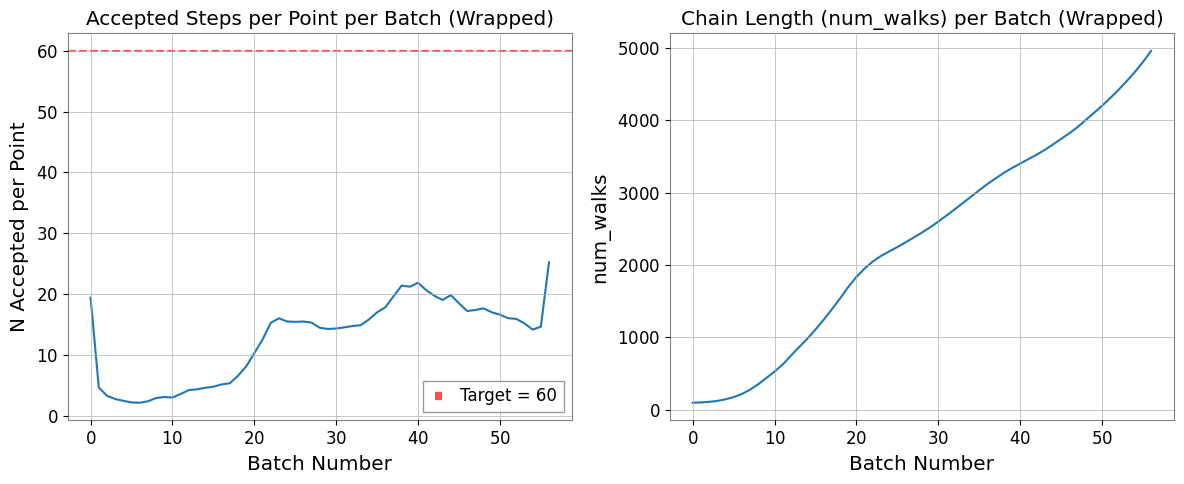

Mean accepted steps per point: 12.6 (target: 10)
Chain length adaptation: [np.int32(100), np.int32(105), np.int32(112), np.int32(125), np.int32(147), np.int32(178), np.int32(220), np.int32(279), np.int32(355), np.int32(442), np.int32(530), np.int32(628), np.int32(749), np.int32(868), np.int32(983), np.int32(1110), np.int32(1244), np.int32(1389), np.int32(1538), np.int32(1696), np.int32(1835), np.int32(1952), np.int32(2047), np.int32(2125), np.int32(2187), np.int32(2247), np.int32(2312), np.int32(2379), np.int32(2447), np.int32(2519), np.int32(2598), np.int32(2682), np.int32(2767), np.int32(2854), np.int32(2942), np.int32(3031), np.int32(3116), np.int32(3194), np.int32(3270), np.int32(3337), np.int32(3398), np.int32(3460), np.int32(3520), np.int32(3587), np.int32(3661), np.int32(3740), np.int32(3815), np.int32(3901), np.int32(3998), np.int32(4096), np.int32(4195), np.int32(4301), np.int32(4413), np.int32(4534), np.int32(4660), np.int32(4798), np.int32(4953)]
Total likelihood evaluations

In [44]:
# Extract adaptation diagnostics
if hasattr(final_state, 'inner_kernel_info') and final_state.inner_kernel_info is not None:
    info = final_state.inner_kernel_info
    
    n_accept_per_particle = np.array(info.n_accept)
    n_steps_per_particle = np.array(info.n_steps)
    
    # Group by unique chain lengths to get batch-level statistics
    unique_steps = np.unique(n_steps_per_particle)
    n_accept_per_point_history = []
    num_walks_history = []
    
    for step_count in unique_steps:
        mask = n_steps_per_particle == step_count
        total_accept = np.sum(n_accept_per_particle[mask])
        avg_accept_per_point = total_accept / n_delete
        n_accept_per_point_history.append(avg_accept_per_point)
        num_walks_history.append(step_count)
    
    f, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(n_accept_per_point_history)
    axes[0].axhline(y=60, color='r', linestyle='--', alpha=0.7, label='Target = 60')
    axes[0].set_title("Accepted Steps per Point per Batch (Wrapped)")
    axes[0].set_ylabel("N Accepted per Point")
    axes[0].set_xlabel("Batch Number")
    axes[0].legend()

    axes[1].plot(num_walks_history)
    axes[1].set_title("Chain Length (num_walks) per Batch (Wrapped)")
    axes[1].set_ylabel("num_walks")
    axes[1].set_xlabel("Batch Number")

    f.tight_layout()
    f.savefig("adaptive_chain_diagnostics_wrapped.pdf")
    plt.show()
    
    # CORRECTED: Total likelihood evaluations is just the sum of n_steps (already per-particle)
    total_evals = np.sum(n_steps_per_particle)
    
    print(f"Mean accepted steps per point: {np.mean(n_accept_per_point_history):.1f} (target: 10)")
    print(f"Chain length adaptation: {num_walks_history}")
    print(f"Total likelihood evaluations: {total_evals}")
else:
    print("No adaptation diagnostics available")

Data shape: (29500,) - analyzing 29500 individual NS iterations


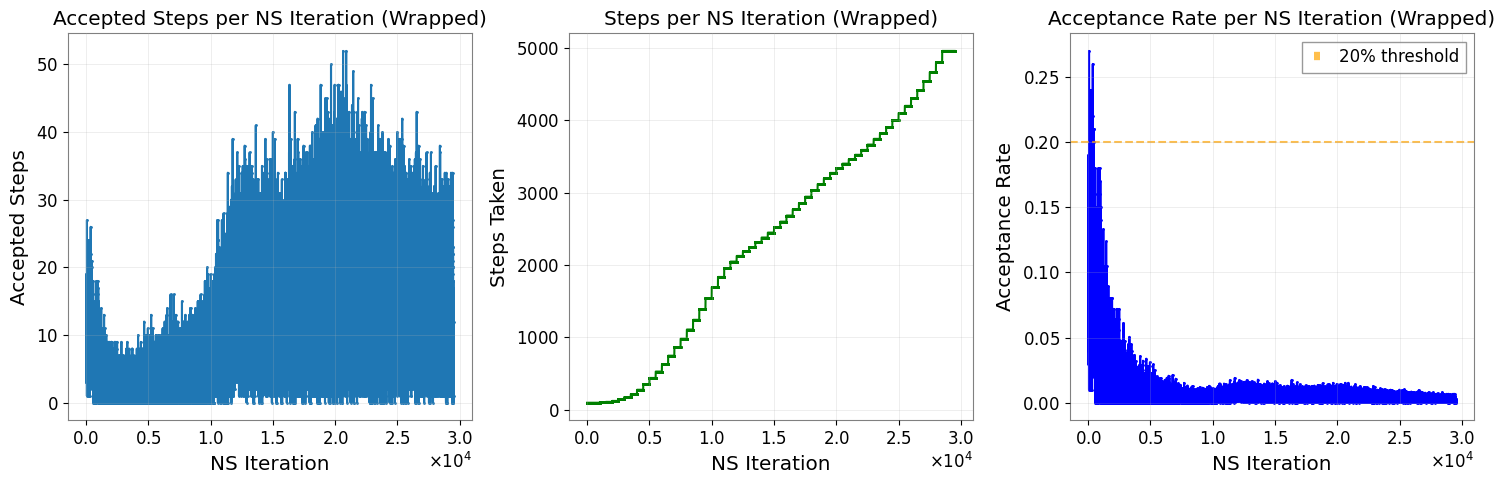

Total likelihood evaluations: 69361000
Total accepted steps: 358261
Overall acceptance rate: 0.005
Mean steps per iteration: 2351.2 ± 1508.8
Iterations with < 20% acceptance: 29484 / 29500 (99.9%)
Sanity check - Accepted range: [0, 52]
Sanity check - Steps range: [100, 4953]


In [45]:
# Extract detailed efficiency diagnostics per individual NS iteration
if hasattr(final_state, 'inner_kernel_info') and final_state.inner_kernel_info is not None:
    info = final_state.inner_kernel_info
    
    if hasattr(info, 'n_accept') and hasattr(info, 'n_steps'):
        n_accept = np.array(info.n_accept)
        n_steps = np.array(info.n_steps)
        
        print(f"Data shape: {n_accept.shape} - analyzing {n_accept.shape[0]} individual NS iterations")
        
        # Calculate metrics per individual NS iteration (each deleted particle)
        acceptance_rates = n_accept / n_steps  # Acceptance rate per particle
        mean_steps_per_iteration = np.mean(n_steps)
        std_steps_per_iteration = np.std(n_steps)
        
        # Count iterations with low acceptance (< 20%)
        low_accept_iterations = np.sum(acceptance_rates < 0.2)
        
        f, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Accepted steps per individual NS iteration
        axes[0].plot(n_accept, 'o-', markersize=1)
        axes[0].set_title("Accepted Steps per NS Iteration (Wrapped)")
        axes[0].set_xlabel("NS Iteration")
        axes[0].set_ylabel("Accepted Steps")
        axes[0].grid(True, alpha=0.3)
        
        # Steps taken per individual NS iteration
        axes[1].plot(n_steps, 'o-', color='green', markersize=1)
        axes[1].set_title("Steps per NS Iteration (Wrapped)")
        axes[1].set_xlabel("NS Iteration")
        axes[1].set_ylabel("Steps Taken")
        axes[1].grid(True, alpha=0.3)

        # Acceptance rate per individual NS iteration
        axes[2].plot(acceptance_rates, 'o-', color='blue', markersize=1)
        axes[2].axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='20% threshold')
        axes[2].set_title("Acceptance Rate per NS Iteration (Wrapped)")
        axes[2].set_xlabel("NS Iteration")
        axes[2].set_ylabel("Acceptance Rate")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        f.tight_layout()
        f.savefig("bilby_wrapped_performance.pdf")
        plt.show()
        
        # Summary statistics
        n_iterations = len(n_accept)
        total_evals = np.sum(n_steps)
        total_accepted = np.sum(n_accept)
        overall_acceptance = total_accepted / total_evals
        
        print(f"Total likelihood evaluations: {total_evals}")
        print(f"Total accepted steps: {total_accepted}")
        print(f"Overall acceptance rate: {overall_acceptance:.3f}")
        print(f"Mean steps per iteration: {mean_steps_per_iteration:.1f} ± {std_steps_per_iteration:.1f}")
        print(f"Iterations with < 20% acceptance: {low_accept_iterations} / {n_iterations} ({100*low_accept_iterations/n_iterations:.1f}%)")
        
        # Sanity checks
        min_accepted = np.min(n_accept)
        max_accepted = np.max(n_accept)
        min_steps = np.min(n_steps)
        max_steps = np.max(n_steps)
        print(f"Sanity check - Accepted range: [{min_accepted}, {max_accepted}]")
        print(f"Sanity check - Steps range: [{min_steps}, {max_steps}]")
        
    else:
        print("No detailed diagnostics available")
else:
    print("No kernel info available")

In [ ]:
# Save nested sampling results
from anesthetic import NestedSamples
import numpy as np

# Process dead points structure
dead = jax.tree.map(
    lambda *args: jnp.reshape(
        jnp.stack(args, axis=0), (-1,) + args[0].shape[1:]
    ),
    *dead,
)
live = state

# Combine log-likelihoods
logL = np.concatenate((dead.loglikelihood, live.loglikelihood), dtype=float)
logL_birth = np.concatenate((dead.loglikelihood_birth, live.loglikelihood_birth), dtype=float)
logL_birth = np.where(np.isnan(logL_birth), -np.inf, logL_birth)

# Transform unit cube samples to physical space
dead_physical = transform_to_physical(dead.particles, prior_transform_fn)
live_physical = transform_to_physical(live.particles, prior_transform_fn)

# Extract parameter data for sampled parameters only
dead_data = np.column_stack([dead_physical[key] for key in sample_keys])
live_data = np.column_stack([live_physical[key] for key in sample_keys])
data = np.concatenate([dead_data, live_data], axis=0)

# Create labels for sampled parameters
sampled_labels = {key: column_to_label[key] for key in sample_keys}

# Create NestedSamples object
samples = NestedSamples(
    data, 
    logL=logL, 
    logL_birth=logL_birth, 
    columns=sample_keys,
    labels=sampled_labels
)

# Save to CSV
output_filename = "bilbykernel_unitcube_4s.csv"
samples.to_csv(output_filename)